# 1) Installing and Importing Packages

## 1.1) Installing the Packages

In [1]:
!pip install roboflow ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.2/949.2 kB 26.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.


## 1.2) Importing Required Libraries

In [2]:
# Standard libraries
import os
import logging
import torch
import pandas as pd

# Roboflow for dataset handling
from roboflow import Roboflow

# YOLO model from Ultralytics
from ultralytics import YOLO

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import FileLink


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# 2) Dataset Preparation

## 2.1) Checking GPU Availability

In [3]:
# Check for available GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Used device : {device}")  # Display the device being used (GPU if available, otherwise CPU)

Used device : cuda


## 2.2) Downloading the Dataset

In [4]:
# Initialize the Roboflow API with the provided API key
rf = Roboflow(api_key="otOtGdUBahdhSaqUYdPf")

# Access the specified project within the workspace
project = rf.workspace("thibaut-juill-669vr").project("lyon2-corbeau-mouette-pigeon")

# Retrieve version 1 of the dataset
version = project.version(1)

# Download the dataset in YOLOv11 format
dataset = version.download("yolov11")

# Store the dataset path
dataset_path = dataset.location

# Print the location where the dataset was downloaded
print(f"Dataset downloaded to {dataset_path}")


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to LYON2---Corbeau-Mouette-Pigeon-1 in yolov11:: 100%|██████████| 390/390 [00:00<00:00, 8354.08it/s]

Dataset downloaded to /kaggle/working/LYON2---Corbeau-Mouette-Pigeon-1


In [ ]:
# Or if you have the dataset locally
# dataset_path = "./LYON2---Corbeau-Mouette-Pigeon-1"

## 2.3) Displaying Sample Images

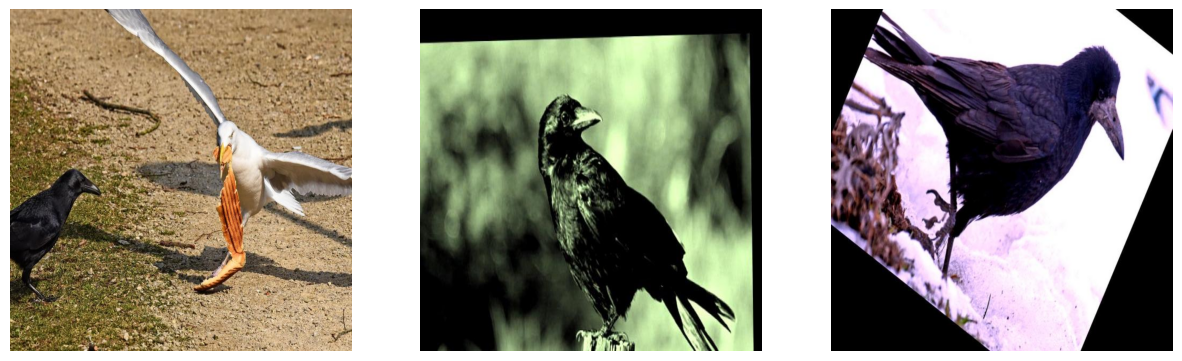

In [5]:
# Define the path to sample images from the training set
sample_images = os.path.join(dataset_path, "train", "images")

# Select the first three image files from the training dataset
img_files = [os.path.join(sample_images, f) for f in os.listdir(sample_images)[:3]]

# Display the selected images
plt.figure(figsize=(15, 10))  # Set figure size

for i, img_path in enumerate(img_files):
    plt.subplot(1, 3, i+1)  # Create a subplot for each image
    img = mpimg.imread(img_path)  # Load the image
    plt.imshow(img)  # Display the image
    plt.axis('off')  # Hide axes

plt.show()  # Show the images


# 3) Model Training Configuration

## 3.1) Loading the YOLO Model

In [6]:
# Load the YOLO model
model = YOLO("yolo11n.pt")  # Using the nano version for a good balance between speed and accuracy


100%|██████████| 5.35M/5.35M [00:00<00:00, 105MB/s]


# 4) Hyperparameter Tuning with Multiple Training Runs

## 4.1) Defining Hyperparameter Variations

In [7]:
# Define a list of hyperparameter configurations to test
hyperparameter_tests = [
    {"epochs": 50, "imgsz": 640, "batch": 16, "optimizer": "Adam", "lr0": 0.001, "name": "test_adam_lr0.001"},
    {"epochs": 50, "imgsz": 640, "batch": 16, "optimizer": "SGD", "lr0": 0.01, "name": "test_sgd_lr0.01"},
    {"epochs": 50, "imgsz": 640, "batch": 32, "optimizer": "Adam", "lr0": 0.0005, "name": "test_adam_lr0.0005"},
]

# Initialize an empty DataFrame to store the results of each run
results_df = pd.DataFrame(columns=["Run", "mAP50", "Precision", "Recall", "Best Model Path"])


## 4.2) Running Multiple Training Sessions

In [8]:
# Initialize a list to store results before creating the DataFrame
results_list = []

# Iterate over each hyperparameter configuration
for i, params in enumerate(hyperparameter_tests):
    print(f"\n--- Training Run {i+1}: {params['name']} ---\n")

    # Train the model using the current set of hyperparameters
    results = model.train(
        data=os.path.join(dataset_path, "data.yaml"),  # Path to dataset configuration
        epochs=params["epochs"],  # Number of training epochs
        imgsz=params["imgsz"],  # Image size for training
        batch=params["batch"],  # Batch size
        optimizer=params["optimizer"],  # Optimization algorithm
        lr0=params["lr0"],  # Initial learning rate
        device=device,  # Use GPU if available
        name=params["name"]  # Naming the training run
    )

    # Retrieve the path of the best trained model
    best_model_path = os.path.join("runs", "detect", params["name"], "weights", "best.pt")

    # Perform a quick evaluation after training
    metrics = model.val(data=os.path.join(dataset_path, "data.yaml"))

    # Store the results in the list
    results_list.append({
        "Run": params["name"],
        "mAP50": metrics.box.map50,  # Mean Average Precision at 50% IoU
        "Precision": metrics.box.map,  # Overall model precision
        "Recall": metrics.box.mr,  # Model recall
        "Best Model Path": best_model_path  # Path to the best model weights
    })

# Create a DataFrame after collecting all results
results_df = pd.DataFrame(results_list)



--- Training Run 1: test_adam_lr0.001 ---

Ultralytics 8.3.91 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/working/LYON2---Corbeau-Mouette-Pigeon-1/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=test_adam_lr0.001, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=F

100%|██████████| 755k/755k [00:00<00:00, 28.8MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/working/LYON2---Corbeau-Mouette-Pigeon-1/train/labels... 132 images, 0 backgrounds, 0 corrupt: 100%|██████████| 132/132 [00:00<00:00, 1090.55it/s]

train: New cache created: /kaggle/working/LYON2---Corbeau-Mouette-Pigeon-1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /kaggle/working/LYON2---Corbeau-Mouette-Pigeon-1/valid/labels... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<00:00, 1740.79it/s]

val: New cache created: /kaggle/working/LYON2---Corbeau-Mouette-Pigeon-1/valid/labels.cache


Plotting labels to runs/detect/test_adam_lr0.001/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/test_adam_lr0.001
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       2.5G      1.371      3.294      1.621         16        640: 100%|██████████| 9/9 [00:03<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all         38         84    0.00268      0.474     0.0473      0.018



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.74G      1.229      2.884       1.51         14        640: 100%|██████████| 9/9 [00:02<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]

                   all         38         84    0.00303      0.455      0.035      0.012



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.75G      1.303      2.563      1.551         12        640: 100%|██████████| 9/9 [00:01<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]

                   all         38         84    0.00353      0.504     0.0742      0.027



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.75G      1.307      2.383       1.55         16        640: 100%|██████████| 9/9 [00:01<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.02it/s]

                   all         38         84    0.00375      0.543     0.0995     0.0418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.75G      1.289       2.22      1.545          9        640: 100%|██████████| 9/9 [00:01<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.45it/s]

                   all         38         84    0.00524      0.713      0.169     0.0873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.75G      1.308       2.03       1.49         23        640: 100%|██████████| 9/9 [00:01<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]

                   all         38         84      0.056      0.663       0.25       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.75G       1.26      1.949      1.472         33        640: 100%|██████████| 9/9 [00:01<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]

                   all         38         84      0.778      0.235      0.324      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.75G      1.204      1.784      1.429         15        640: 100%|██████████| 9/9 [00:01<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]

                   all         38         84      0.382      0.334      0.329      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.75G      1.297      1.706      1.515         10        640: 100%|██████████| 9/9 [00:01<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.36it/s]

                   all         38         84      0.615      0.395      0.512      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.75G      1.247      1.796      1.458         15        640: 100%|██████████| 9/9 [00:01<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]

                   all         38         84      0.404      0.488      0.441      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.75G      1.171      1.628      1.426         10        640: 100%|██████████| 9/9 [00:01<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.13it/s]

                   all         38         84      0.514      0.374      0.362      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.75G      1.188      1.642      1.449         18        640: 100%|██████████| 9/9 [00:01<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.50it/s]

                   all         38         84      0.544      0.348      0.365      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.75G      1.201      1.553      1.438         10        640: 100%|██████████| 9/9 [00:01<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]

                   all         38         84      0.542      0.432      0.448      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.75G      1.226      1.618      1.508          7        640: 100%|██████████| 9/9 [00:01<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.17it/s]

                   all         38         84      0.391      0.644      0.501      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.75G      1.201      1.624      1.464          6        640: 100%|██████████| 9/9 [00:01<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.80it/s]

                   all         38         84      0.543      0.566      0.629      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.75G      1.135      1.483      1.416         13        640: 100%|██████████| 9/9 [00:01<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.81it/s]

                   all         38         84      0.701      0.679      0.715      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.75G      1.124      1.452      1.395         16        640: 100%|██████████| 9/9 [00:01<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.83it/s]

                   all         38         84      0.739      0.723      0.736       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.75G      1.064      1.334      1.336         17        640: 100%|██████████| 9/9 [00:01<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]

                   all         38         84      0.762      0.678      0.785      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.75G      1.166      1.396      1.422         10        640: 100%|██████████| 9/9 [00:01<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.13it/s]

                   all         38         84       0.66      0.749       0.74       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.75G      1.126      1.395      1.368         14        640: 100%|██████████| 9/9 [00:01<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.05it/s]

                   all         38         84      0.643      0.685      0.735      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.75G      1.141      1.332      1.375         16        640: 100%|██████████| 9/9 [00:01<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.42it/s]

                   all         38         84      0.666      0.735      0.749      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.75G      1.103      1.343      1.366         12        640: 100%|██████████| 9/9 [00:01<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.63it/s]

                   all         38         84      0.715      0.761      0.761      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.75G      1.108      1.341      1.391         10        640: 100%|██████████| 9/9 [00:01<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.17it/s]

                   all         38         84      0.778      0.758      0.799      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.75G      1.014      1.229      1.294         12        640: 100%|██████████| 9/9 [00:01<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.15it/s]

                   all         38         84      0.781      0.819      0.847       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.75G      1.086      1.247      1.368         15        640: 100%|██████████| 9/9 [00:01<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.07it/s]

                   all         38         84      0.797      0.751      0.808      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.75G      1.082      1.301      1.382         16        640: 100%|██████████| 9/9 [00:01<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.26it/s]

                   all         38         84      0.848      0.653      0.801      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.75G      1.027      1.199      1.282         14        640: 100%|██████████| 9/9 [00:01<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.29it/s]

                   all         38         84      0.845      0.737      0.829      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.75G     0.9636      1.187      1.332         10        640: 100%|██████████| 9/9 [00:01<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.73it/s]

                   all         38         84      0.858      0.764       0.89      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.75G      1.072      1.232      1.388          5        640: 100%|██████████| 9/9 [00:01<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.47it/s]

                   all         38         84      0.856      0.793      0.876      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.75G       1.03      1.157      1.333         17        640: 100%|██████████| 9/9 [00:01<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.03it/s]

                   all         38         84      0.856      0.778      0.865      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.75G      1.053      1.155      1.306         20        640: 100%|██████████| 9/9 [00:01<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.03it/s]

                   all         38         84      0.804      0.838      0.879      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.75G     0.9741      1.091      1.329         13        640: 100%|██████████| 9/9 [00:01<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.28it/s]

                   all         38         84      0.923      0.813      0.921      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.75G      1.022      1.143       1.31         11        640: 100%|██████████| 9/9 [00:01<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.55it/s]

                   all         38         84      0.907       0.78       0.92      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.75G      1.006       1.06      1.273         19        640: 100%|██████████| 9/9 [00:01<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.82it/s]

                   all         38         84       0.85      0.824      0.913      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.75G      1.015       1.11      1.311         12        640: 100%|██████████| 9/9 [00:01<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.43it/s]

                   all         38         84      0.808       0.81      0.891      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.75G     0.9695      1.047      1.282         21        640: 100%|██████████| 9/9 [00:01<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.60it/s]

                   all         38         84      0.935       0.72      0.909      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.75G     0.9336      1.077      1.245         11        640: 100%|██████████| 9/9 [00:01<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.14it/s]

                   all         38         84      0.942      0.702      0.901      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.75G     0.9371      1.032      1.261         15        640: 100%|██████████| 9/9 [00:01<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.26it/s]

                   all         38         84      0.884      0.751      0.892      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.75G     0.8818     0.9229      1.218         21        640: 100%|██████████| 9/9 [00:01<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.26it/s]

                   all         38         84       0.86      0.806      0.895      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.75G     0.9662     0.9851      1.279         19        640: 100%|██████████| 9/9 [00:01<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.03it/s]

                   all         38         84      0.885      0.829      0.909      0.634


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.75G     0.7934     0.9736      1.206          7        640: 100%|██████████| 9/9 [00:02<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.16it/s]

                   all         38         84      0.903      0.803      0.932      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.75G     0.8041     0.9145      1.151          9        640: 100%|██████████| 9/9 [00:01<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.89it/s]

                   all         38         84      0.879      0.819      0.928      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.75G      0.781     0.9121      1.173          8        640: 100%|██████████| 9/9 [00:01<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.05it/s]

                   all         38         84      0.887      0.812      0.912      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.75G     0.7722     0.8552      1.148          9        640: 100%|██████████| 9/9 [00:01<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.89it/s]

                   all         38         84      0.879       0.85      0.925      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.75G     0.7419     0.9011      1.205          4        640: 100%|██████████| 9/9 [00:01<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.24it/s]

                   all         38         84      0.913      0.881      0.937      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.75G     0.7399     0.8475      1.136         11        640: 100%|██████████| 9/9 [00:01<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.81it/s]

                   all         38         84      0.906       0.91      0.948      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.75G     0.7569     0.8215      1.131          9        640: 100%|██████████| 9/9 [00:01<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.47it/s]

                   all         38         84      0.896      0.902      0.951       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.75G     0.7346     0.9016      1.171          5        640: 100%|██████████| 9/9 [00:01<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.31it/s]

                   all         38         84      0.874      0.921      0.955      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.75G     0.6838     0.8014      1.129          4        640: 100%|██████████| 9/9 [00:01<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.27it/s]

                   all         38         84      0.881       0.91      0.953      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.75G     0.6742      0.799      1.108         16        640: 100%|██████████| 9/9 [00:01<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.00it/s]

                   all         38         84      0.898      0.921      0.958      0.697



50 epochs completed in 0.036 hours.
Optimizer stripped from runs/detect/test_adam_lr0.001/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/test_adam_lr0.001/weights/best.pt, 5.5MB

Validating runs/detect/test_adam_lr0.001/weights/best.pt...
Ultralytics 8.3.91 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.01it/s]


                   all         38         84      0.898      0.922      0.958      0.697
                  crow         17         17          1       0.99      0.995      0.835
                pigeon         10         34       0.82      0.806      0.896      0.583
               seagull         14         33      0.873       0.97      0.982      0.673


invalid value encountered in less
invalid value encountered in less


Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/test_adam_lr0.001
Ultralytics 8.3.91 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /kaggle/working/LYON2---Corbeau-Mouette-Pigeon-1/valid/labels.cache... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


                   all         38         84      0.898      0.921      0.958      0.698
                  crow         17         17          1      0.991      0.995      0.835
                pigeon         10         34       0.82      0.803      0.896      0.585
               seagull         14         33      0.873       0.97      0.982      0.674


invalid value encountered in less
invalid value encountered in less


Speed: 5.5ms preprocess, 11.1ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/test_adam_lr0.0012

--- Training Run 2: test_sgd_lr0.01 ---

Ultralytics 8.3.91 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/working/LYON2---Corbeau-Mouette-Pigeon-1/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=test_sgd_lr0.01, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=Fals

train: Scanning /kaggle/working/LYON2---Corbeau-Mouette-Pigeon-1/train/labels.cache... 132 images, 0 backgrounds, 0 corrupt: 100%|██████████| 132/132 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/LYON2---Corbeau-Mouette-Pigeon-1/valid/labels.cache... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]


Plotting labels to runs/detect/test_sgd_lr0.01/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/test_sgd_lr0.01
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.53G      2.841      3.391      2.844         16        640: 100%|██████████| 9/9 [00:02<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.11it/s]

                   all         38         84    0.00396      0.535     0.0273     0.0158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.77G      2.648      3.147      2.654         14        640: 100%|██████████| 9/9 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]

                   all         38         84      0.156     0.0983     0.0808     0.0366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.77G      2.461      2.793       2.43         12        640: 100%|██████████| 9/9 [00:01<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.90it/s]

                   all         38         84      0.664     0.0536      0.184     0.0854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.77G      2.317      2.685      2.379         16        640: 100%|██████████| 9/9 [00:01<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.00it/s]

                   all         38         84      0.701      0.218      0.329      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.77G      2.113      2.377      2.217          9        640: 100%|██████████| 9/9 [00:01<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.71it/s]

                   all         38         84      0.581      0.417      0.439      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.77G      1.927      2.064      2.038         23        640: 100%|██████████| 9/9 [00:01<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.36it/s]

                   all         38         84      0.703      0.413      0.528      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.77G      1.798      2.051      1.963         33        640: 100%|██████████| 9/9 [00:01<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.79it/s]

                   all         38         84      0.505      0.495      0.508      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.77G        1.7      1.905      1.863         15        640: 100%|██████████| 9/9 [00:01<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.39it/s]

                   all         38         84      0.697      0.605      0.645        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.77G      1.661      1.781      1.833         10        640: 100%|██████████| 9/9 [00:01<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]

                   all         38         84      0.719      0.609      0.687      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.77G      1.594      1.819      1.756         15        640: 100%|██████████| 9/9 [00:01<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.32it/s]

                   all         38         84      0.615      0.598      0.653      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.77G      1.395      1.587      1.627         10        640: 100%|██████████| 9/9 [00:01<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.15it/s]

                   all         38         84      0.637      0.694      0.705      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.77G      1.441      1.614      1.671         18        640: 100%|██████████| 9/9 [00:01<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.94it/s]

                   all         38         84      0.664       0.74      0.773      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.77G      1.311      1.461       1.57         10        640: 100%|██████████| 9/9 [00:01<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.99it/s]

                   all         38         84      0.884       0.69      0.807      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.77G      1.313      1.564      1.584          7        640: 100%|██████████| 9/9 [00:01<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.50it/s]

                   all         38         84      0.747      0.693      0.759       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.77G      1.337      1.683      1.585          6        640: 100%|██████████| 9/9 [00:01<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.27it/s]

                   all         38         84      0.755      0.684      0.768      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.77G      1.275      1.426      1.529         13        640: 100%|██████████| 9/9 [00:01<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]

                   all         38         84      0.824      0.678      0.788      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.77G      1.271      1.373      1.494         16        640: 100%|██████████| 9/9 [00:01<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.87it/s]

                   all         38         84      0.842        0.7      0.812      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.77G      1.178      1.251      1.444         17        640: 100%|██████████| 9/9 [00:01<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.83it/s]

                   all         38         84      0.802      0.733      0.813      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.77G      1.248      1.366      1.523         10        640: 100%|██████████| 9/9 [00:01<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.37it/s]

                   all         38         84      0.756      0.788      0.842      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.77G      1.187       1.31      1.439         14        640: 100%|██████████| 9/9 [00:01<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.73it/s]

                   all         38         84      0.828      0.753      0.864      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.77G      1.178      1.307       1.42         16        640: 100%|██████████| 9/9 [00:01<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]

                   all         38         84       0.88      0.818      0.882      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.77G       1.21      1.333      1.452         12        640: 100%|██████████| 9/9 [00:01<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.23it/s]

                   all         38         84      0.839      0.817      0.855      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.77G      1.138      1.309      1.427         10        640: 100%|██████████| 9/9 [00:01<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.49it/s]

                   all         38         84        0.8      0.792      0.834      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.77G      1.085      1.268      1.365         12        640: 100%|██████████| 9/9 [00:01<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.35it/s]

                   all         38         84       0.84      0.747      0.839      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.77G      1.145      1.255      1.402         15        640: 100%|██████████| 9/9 [00:01<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.25it/s]

                   all         38         84      0.903      0.744      0.859      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.77G      1.112      1.258      1.421         16        640: 100%|██████████| 9/9 [00:01<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.76it/s]

                   all         38         84      0.827      0.831      0.886      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.77G      1.024        1.1      1.292         14        640: 100%|██████████| 9/9 [00:01<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.12it/s]

                   all         38         84      0.879      0.802      0.885      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.77G      1.018       1.19      1.379         10        640: 100%|██████████| 9/9 [00:01<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.97it/s]

                   all         38         84      0.932      0.748      0.889      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.77G      1.078      1.217      1.394          5        640: 100%|██████████| 9/9 [00:01<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.49it/s]

                   all         38         84      0.932      0.764      0.887      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.77G      1.037      1.139      1.342         17        640: 100%|██████████| 9/9 [00:01<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.61it/s]

                   all         38         84      0.928      0.779      0.901      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.77G      1.037      1.099      1.307         20        640: 100%|██████████| 9/9 [00:01<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.11it/s]

                   all         38         84      0.924      0.827      0.909      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.77G          1      1.083      1.372         13        640: 100%|██████████| 9/9 [00:01<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.76it/s]

                   all         38         84      0.921      0.831      0.924      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.77G       1.03      1.136      1.317         11        640: 100%|██████████| 9/9 [00:01<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.41it/s]

                   all         38         84      0.923      0.881       0.94      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.77G     0.9994      1.104        1.3         19        640: 100%|██████████| 9/9 [00:01<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.02it/s]

                   all         38         84       0.94      0.871       0.94      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.77G      1.017      1.117       1.34         12        640: 100%|██████████| 9/9 [00:01<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.19it/s]

                   all         38         84      0.917      0.893      0.934      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.77G     0.9956      1.091      1.311         21        640: 100%|██████████| 9/9 [00:01<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.79it/s]

                   all         38         84      0.951      0.869      0.931      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.77G     0.9863      1.116      1.296         11        640: 100%|██████████| 9/9 [00:01<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.40it/s]

                   all         38         84      0.973      0.828      0.929      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.77G     0.9712      1.059      1.309         15        640: 100%|██████████| 9/9 [00:01<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.44it/s]

                   all         38         84      0.967      0.834      0.925      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.77G     0.9329     0.9599      1.256         21        640: 100%|██████████| 9/9 [00:01<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.98it/s]

                   all         38         84      0.959      0.842      0.929      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.77G      1.007      1.031      1.301         19        640: 100%|██████████| 9/9 [00:01<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.73it/s]

                   all         38         84      0.951      0.846      0.929      0.651


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.77G     0.8508      1.098      1.284          7        640: 100%|██████████| 9/9 [00:02<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]

                   all         38         84      0.882      0.892      0.929      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.77G     0.8251     0.9744      1.201          9        640: 100%|██████████| 9/9 [00:01<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.05it/s]

                   all         38         84      0.908      0.857      0.919      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.77G     0.8217     0.9546      1.233          8        640: 100%|██████████| 9/9 [00:01<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.65it/s]

                   all         38         84      0.914      0.842       0.93      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.77G     0.7924     0.9482      1.199          9        640: 100%|██████████| 9/9 [00:01<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.27it/s]

                   all         38         84      0.921      0.844      0.923      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.77G     0.7874      1.007      1.255          4        640: 100%|██████████| 9/9 [00:01<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.94it/s]

                   all         38         84      0.926      0.842      0.935      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.77G     0.7651     0.9576      1.183         11        640: 100%|██████████| 9/9 [00:01<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.76it/s]

                   all         38         84      0.951      0.821       0.93      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.77G     0.8059     0.9586      1.187          9        640: 100%|██████████| 9/9 [00:01<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.40it/s]

                   all         38         84      0.964      0.818       0.93      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.77G     0.7962     0.9397      1.242          5        640: 100%|██████████| 9/9 [00:01<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.14it/s]

                   all         38         84      0.871      0.882      0.927      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.77G     0.7488     0.9192      1.197          4        640: 100%|██████████| 9/9 [00:01<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.13it/s]

                   all         38         84       0.88      0.881      0.929      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.77G     0.7519     0.9308      1.172         16        640: 100%|██████████| 9/9 [00:01<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]

                   all         38         84      0.882      0.885      0.935      0.661



50 epochs completed in 0.035 hours.
Optimizer stripped from runs/detect/test_sgd_lr0.01/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/test_sgd_lr0.01/weights/best.pt, 5.5MB

Validating runs/detect/test_sgd_lr0.01/weights/best.pt...
Ultralytics 8.3.91 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.01it/s]


                   all         38         84      0.949      0.842      0.927      0.665
                  crow         17         17      0.975          1      0.995      0.818
                pigeon         10         34      0.936      0.676      0.849      0.551
               seagull         14         33      0.936      0.848      0.938      0.626


invalid value encountered in less
invalid value encountered in less


Speed: 0.2ms preprocess, 5.0ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/test_sgd_lr0.01
Ultralytics 8.3.91 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /kaggle/working/LYON2---Corbeau-Mouette-Pigeon-1/valid/labels.cache... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


                   all         38         84      0.959      0.842      0.934      0.666
                  crow         17         17      0.974          1      0.995      0.818
                pigeon         10         34      0.935      0.676      0.863      0.552
               seagull         14         33      0.968      0.848      0.944      0.628


invalid value encountered in less
invalid value encountered in less


Speed: 5.6ms preprocess, 4.9ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/detect/test_sgd_lr0.012

--- Training Run 3: test_adam_lr0.0005 ---

Ultralytics 8.3.91 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/working/LYON2---Corbeau-Mouette-Pigeon-1/data.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=test_adam_lr0.0005, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=

train: Scanning /kaggle/working/LYON2---Corbeau-Mouette-Pigeon-1/train/labels.cache... 132 images, 0 backgrounds, 0 corrupt: 100%|██████████| 132/132 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/LYON2---Corbeau-Mouette-Pigeon-1/valid/labels.cache... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]


Plotting labels to runs/detect/test_adam_lr0.0005/labels.jpg... 
optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/test_adam_lr0.0005
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.49G      1.046      1.161      1.364         16        640: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         38         84      0.556      0.138      0.188     0.0799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.86G      1.105      1.207      1.424         12        640: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]

                   all         38         84      0.465      0.199      0.338      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.86G       1.12      1.099       1.41         13        640: 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

                   all         38         84      0.621        0.4      0.448       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.86G      1.127      1.128      1.395         24        640: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all         38         84      0.704      0.538      0.578      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.86G      1.087      1.036      1.393         10        640: 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

                   all         38         84      0.713      0.623       0.68        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.86G      1.108      1.023      1.322         23        640: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

                   all         38         84      0.788      0.675      0.731      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.86G       1.04     0.9979      1.272         16        640: 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         38         84      0.768      0.643      0.765      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.86G       1.06      1.014      1.372         15        640: 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

                   all         38         84      0.765      0.605      0.695      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.86G     0.9486     0.8807      1.286         11        640: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all         38         84      0.632      0.677      0.698      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.86G      1.077      1.166      1.351         12        640: 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

                   all         38         84      0.711      0.653      0.706      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.86G     0.9626      1.121      1.268         10        640: 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all         38         84      0.761      0.719      0.766       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.86G     0.8675     0.8715      1.262         16        640: 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

                   all         38         84      0.797      0.754      0.806      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.86G     0.8788     0.8518      1.226         12        640: 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]

                   all         38         84       0.79      0.781      0.827      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.86G     0.9185     0.9722      1.267          6        640: 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all         38         84      0.806      0.785      0.843      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.86G     0.9854      1.043      1.341          9        640: 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

                   all         38         84      0.892      0.784      0.871      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.86G      0.918     0.8677      1.235         19        640: 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]

                   all         38         84      0.918      0.786      0.882      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.86G      0.887     0.8727      1.235         18        640: 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all         38         84      0.905      0.803      0.893      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.86G       0.84     0.8765      1.199         18        640: 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         38         84      0.981      0.823      0.917      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.86G     0.9748      0.984       1.33         11        640: 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]

                   all         38         84      0.941      0.862      0.931      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.86G      1.017      1.026      1.301         21        640: 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

                   all         38         84      0.955      0.872      0.939      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.86G     0.9686     0.9383      1.258         22        640: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]

                   all         38         84      0.959       0.86      0.944      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.86G     0.9242     0.8486      1.313          9        640: 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]

                   all         38         84      0.953      0.859      0.948      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.86G     0.8493     0.8586      1.219          9        640: 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

                   all         38         84      0.948      0.862       0.95      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.86G     0.8866     0.8394      1.243          7        640: 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]

                   all         38         84      0.942       0.85      0.955      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.86G     0.8625     0.8255      1.232         13        640: 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all         38         84       0.94      0.862      0.954      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.86G     0.8899     0.9135      1.325          9        640: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]

                   all         38         84      0.953      0.848      0.934      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.86G     0.8758     0.8124      1.216          9        640: 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

                   all         38         84      0.959      0.862      0.937      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.86G     0.8404     0.8367      1.203         11        640: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

                   all         38         84      0.953      0.884      0.943      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.86G     0.8709      0.876      1.285          5        640: 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

                   all         38         84      0.974      0.873      0.948      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.86G     0.8625     0.8331      1.197         15        640: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]

                   all         38         84      0.984      0.862      0.953      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.86G     0.8367     0.7338      1.209         17        640: 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

                   all         38         84      0.983      0.865      0.951      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.86G     0.8965     0.8131      1.295         12        640: 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all         38         84      0.988      0.859      0.945      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.86G     0.8788     0.8038      1.213          9        640: 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

                   all         38         84      0.988      0.866       0.96      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.86G     0.8405     0.7749      1.166         15        640: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

                   all         38         84      0.956      0.885      0.959      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.86G     0.8641     0.8739       1.25         14        640: 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

                   all         38         84      0.945      0.862      0.955      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.86G     0.7972     0.7464      1.178         20        640: 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

                   all         38         84      0.951      0.858      0.956      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.86G     0.8956     0.8094      1.225         16        640: 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

                   all         38         84      0.947      0.851      0.956      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.86G     0.9047     0.8375      1.216         20        640: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

                   all         38         84      0.952      0.857      0.955      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.86G     0.8474     0.8249      1.167         20        640: 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

                   all         38         84      0.974      0.835      0.949      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.86G     0.8385     0.7732      1.202         16        640: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

                   all         38         84      0.971      0.845      0.948      0.699


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.86G     0.8015     0.8039      1.178          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

                   all         38         84      0.972      0.855      0.948       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.86G       0.77     0.8268      1.172          8        640: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

                   all         38         84      0.981      0.848      0.946      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.86G     0.7002     0.6659      1.132          9        640: 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         38         84      0.984      0.858       0.94      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.86G     0.6722      0.737      1.189          4        640: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all         38         84      0.984      0.856       0.94       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.86G     0.7527     0.7149      1.145         11        640: 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

                   all         38         84      0.984      0.853      0.938      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.86G     0.7658     0.7262      1.124          9        640: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

                   all         38         84      0.967      0.841      0.936       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.86G     0.7334     0.7254      1.125          5        640: 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]

                   all         38         84      0.972      0.836      0.941      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.86G     0.6961     0.7146      1.175          4        640: 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]

                   all         38         84      0.887      0.909      0.949      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.86G     0.7124     0.7153      1.109         17        640: 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]

                   all         38         84      0.975      0.852      0.948      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.86G     0.7016     0.6302        1.1          4        640: 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

                   all         38         84       0.97      0.852      0.949      0.667



50 epochs completed in 0.033 hours.
Optimizer stripped from runs/detect/test_adam_lr0.0005/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/test_adam_lr0.0005/weights/best.pt, 5.5MB

Validating runs/detect/test_adam_lr0.0005/weights/best.pt...
Ultralytics 8.3.91 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


                   all         38         84      0.964      0.849      0.956      0.715
                  crow         17         17      0.968          1      0.995      0.864
                pigeon         10         34      0.955       0.62      0.913      0.614
               seagull         14         33      0.968      0.927      0.959      0.668


invalid value encountered in less
invalid value encountered in less


Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/test_adam_lr0.0005
Ultralytics 8.3.91 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /kaggle/working/LYON2---Corbeau-Mouette-Pigeon-1/valid/labels.cache... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


                   all         38         84      0.945      0.862      0.955      0.714
                  crow         17         17      0.942          1      0.995       0.86
                pigeon         10         34      0.956      0.647      0.913      0.613
               seagull         14         33      0.936      0.939      0.958      0.668


invalid value encountered in less
invalid value encountered in less


Speed: 4.8ms preprocess, 5.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/test_adam_lr0.00052


## 4.3) Saving the Results to a CSV File

In [9]:
# Save the training results to a CSV file
results_df.to_csv("training_results.csv", index=False)

# Print confirmation message
print("\nTraining history saved in training_results.csv")


Training history saved in training_results.csv


# 5) Defining the Best Training Hyperparameters

## 5.1) Selecting the Best Configuration

In [10]:
# Select the best hyperparameters based on the highest mAP@50 score
best_params = results_df.sort_values(by="mAP50", ascending=False).iloc[0]

# Print the name of the best training run
print(f"Best hyperparameters selected: {best_params['Run']}")

Best hyperparameters selected: test_adam_lr0.001


# 6) Final Model Training with Optimized Parameters


## 6.1) Defining Training Hyperparameters


In [16]:
# Configuration for the final model training
config = {
    "epochs": 50,           # Increase epochs for better convergence
    "imgsz": 640,          # Image size
    "batch": 16,           # Batch size
    "device": device,      # Use GPU if available
    "workers": 2,          # Number of workers for the data loader
    "optimizer": "SGD",    # Selected optimizer (based on best model)
    "lr0": 0.001,           # Learning rate from the best model
    "name": "final_corvidae_detection"  # Name for the final model
}

# TODO : Adapte les paramètres pour le meilleur modèle obtenu dans la partie précédente

## 6.2) Tracking Training Progress (Logging)

In [12]:
# Initialize logging before training
logging.basicConfig(filename="training_logs.log", level=logging.INFO)
logging.info("Training started...")

try:
    # Train the model using the final configuration
    results = model.train(data=os.path.join(dataset_path, "data.yaml"), **config)

    # Log successful training completion
    logging.info(f"Training completed successfully. Best model: {best_model_path}")

except Exception as e:
    # Log any errors encountered during training
    logging.error(f"Error during training: {str(e)}")
    print("Training failed. Check logs for details.")


Ultralytics 8.3.91 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/working/LYON2---Corbeau-Mouette-Pigeon-1/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=2, project=None, name=final_corvidae_detection, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False,

train: Scanning /kaggle/working/LYON2---Corbeau-Mouette-Pigeon-1/train/labels.cache... 132 images, 0 backgrounds, 0 corrupt: 100%|██████████| 132/132 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/LYON2---Corbeau-Mouette-Pigeon-1/valid/labels.cache... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]


Plotting labels to runs/detect/final_corvidae_detection/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/final_corvidae_detection
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.34G     0.9963      1.078      1.317         16        640: 100%|██████████| 9/9 [00:02<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.47it/s]

                   all         38         84      0.792      0.145      0.456       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.58G      1.006      1.039      1.318         17        640: 100%|██████████| 9/9 [00:01<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]

                   all         38         84      0.815      0.491      0.714      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.58G     0.9974       1.04      1.307          7        640: 100%|██████████| 9/9 [00:01<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.94it/s]

                   all         38         84      0.877      0.684      0.838      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.58G     0.9547          1      1.301         11        640: 100%|██████████| 9/9 [00:01<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.97it/s]

                   all         38         84      0.835      0.823      0.894      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.58G     0.9057     0.9372      1.261         22        640: 100%|██████████| 9/9 [00:01<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.33it/s]

                   all         38         84      0.897      0.847      0.921      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.58G     0.9141     0.9278      1.259         15        640: 100%|██████████| 9/9 [00:01<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.22it/s]

                   all         38         84      0.934      0.852      0.948      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.58G      0.861     0.8726       1.22         11        640: 100%|██████████| 9/9 [00:01<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]

                   all         38         84      0.943      0.896      0.953       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.58G     0.8962     0.9181      1.257         16        640: 100%|██████████| 9/9 [00:01<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.81it/s]

                   all         38         84      0.935      0.898      0.956      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.58G     0.9347     0.9397      1.255         24        640: 100%|██████████| 9/9 [00:01<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.80it/s]

                   all         38         84      0.935      0.898      0.954      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.58G     0.9204      0.982       1.28         20        640: 100%|██████████| 9/9 [00:01<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.10it/s]

                   all         38         84      0.912      0.931      0.956      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.58G     0.8887     0.9739      1.253         25        640: 100%|██████████| 9/9 [00:01<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.82it/s]

                   all         38         84      0.965      0.886      0.957      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.58G     0.9349     0.9726      1.261         18        640: 100%|██████████| 9/9 [00:01<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.25it/s]

                   all         38         84      0.934      0.911      0.957      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.58G     0.8435     0.8992      1.245          7        640: 100%|██████████| 9/9 [00:01<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.72it/s]

                   all         38         84      0.917      0.913      0.956      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.58G     0.8574     0.8888       1.22         14        640: 100%|██████████| 9/9 [00:01<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.14it/s]

                   all         38         84      0.959      0.889      0.955      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.58G     0.8554     0.8728      1.236         18        640: 100%|██████████| 9/9 [00:01<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.47it/s]

                   all         38         84      0.957      0.892      0.956      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.58G     0.9258     0.9319      1.278         10        640: 100%|██████████| 9/9 [00:01<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.85it/s]

                   all         38         84       0.98      0.887      0.955      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.58G      0.866     0.8673      1.253         11        640: 100%|██████████| 9/9 [00:01<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.89it/s]

                   all         38         84       0.96       0.89      0.954      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.58G     0.9464     0.9356      1.303          8        640: 100%|██████████| 9/9 [00:02<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.66it/s]

                   all         38         84       0.96      0.891      0.953      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.58G     0.9579     0.9925      1.292         23        640: 100%|██████████| 9/9 [00:01<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]

                   all         38         84      0.958      0.892      0.954      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.58G     0.8621     0.8582      1.242         17        640: 100%|██████████| 9/9 [00:01<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]

                   all         38         84      0.984      0.877      0.954      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.58G     0.9395     0.9314      1.259          9        640: 100%|██████████| 9/9 [00:01<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.04it/s]

                   all         38         84      0.982      0.861      0.953      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.58G     0.9232     0.9336      1.245         17        640: 100%|██████████| 9/9 [00:01<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]

                   all         38         84       0.98      0.862      0.952      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.58G     0.8394     0.9503      1.252          4        640: 100%|██████████| 9/9 [00:01<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.85it/s]

                   all         38         84      0.899      0.922      0.955      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.58G     0.8723     0.9218      1.231         11        640: 100%|██████████| 9/9 [00:01<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.15it/s]

                   all         38         84      0.915      0.917      0.954      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.58G     0.8917     0.9495      1.262         16        640: 100%|██████████| 9/9 [00:01<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.94it/s]

                   all         38         84      0.919      0.921      0.956      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.58G      0.813     0.8681      1.194         13        640: 100%|██████████| 9/9 [00:01<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.54it/s]

                   all         38         84      0.921      0.921      0.958      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.58G     0.8511     0.8651      1.226         17        640: 100%|██████████| 9/9 [00:01<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.53it/s]

                   all         38         84      0.978      0.877      0.958      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.58G     0.8488     0.8969       1.23         13        640: 100%|██████████| 9/9 [00:01<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.69it/s]

                   all         38         84       0.98      0.887      0.958      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.58G     0.8976      0.872      1.265         10        640: 100%|██████████| 9/9 [00:01<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.20it/s]

                   all         38         84      0.991      0.879      0.959      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.58G     0.9271     0.9714      1.287          9        640: 100%|██████████| 9/9 [00:01<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.86it/s]

                   all         38         84      0.983      0.887      0.959      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.58G     0.8083     0.8667      1.227         12        640: 100%|██████████| 9/9 [00:01<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.13it/s]

                   all         38         84      0.984      0.888      0.959      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.58G     0.8078     0.8425      1.206         13        640: 100%|██████████| 9/9 [00:01<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.57it/s]

                   all         38         84      0.979      0.878      0.957      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.58G     0.8541     0.8997      1.223         16        640: 100%|██████████| 9/9 [00:01<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.74it/s]

                   all         38         84      0.977      0.877      0.957      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.58G     0.8758      0.897      1.242          9        640: 100%|██████████| 9/9 [00:01<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.19it/s]

                   all         38         84      0.972      0.877      0.958      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.58G     0.8395      0.872      1.267         15        640: 100%|██████████| 9/9 [00:01<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]

                   all         38         84      0.976      0.876      0.957      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.58G      0.831     0.8795      1.212         10        640: 100%|██████████| 9/9 [00:01<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.83it/s]

                   all         38         84      0.908      0.925      0.957      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.58G     0.9016     0.8636      1.223         16        640: 100%|██████████| 9/9 [00:01<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.70it/s]

                   all         38         84      0.961      0.882      0.957      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.58G      0.873     0.8841      1.218          9        640: 100%|██████████| 9/9 [00:01<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.61it/s]

                   all         38         84      0.914      0.926      0.956      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.58G     0.8949     0.9093      1.266         16        640: 100%|██████████| 9/9 [00:01<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.05it/s]

                   all         38         84      0.918      0.928      0.955      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.58G     0.8334     0.7916      1.207         13        640: 100%|██████████| 9/9 [00:01<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.18it/s]

                   all         38         84      0.913      0.925      0.956      0.711


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.58G     0.7324     0.8962      1.155          7        640: 100%|██████████| 9/9 [00:02<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.72it/s]

                   all         38         84      0.915      0.926      0.953      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.58G      0.786     0.9131      1.175          9        640: 100%|██████████| 9/9 [00:01<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.85it/s]

                   all         38         84      0.921      0.921      0.956      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.58G     0.7235     0.8816      1.156          8        640: 100%|██████████| 9/9 [00:01<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.62it/s]

                   all         38         84      0.916       0.92      0.952      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.58G     0.7466     0.8552       1.16          9        640: 100%|██████████| 9/9 [00:01<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.63it/s]

                   all         38         84      0.911      0.917      0.953      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.58G     0.6583     0.7892      1.114          4        640: 100%|██████████| 9/9 [00:01<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.05it/s]

                   all         38         84      0.974      0.873      0.954        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.58G     0.8219     0.8841      1.192         11        640: 100%|██████████| 9/9 [00:01<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.04it/s]

                   all         38         84      0.903      0.927      0.954      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.58G     0.7675     0.9147      1.231          5        640: 100%|██████████| 9/9 [00:01<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.06it/s]

                   all         38         84      0.937      0.911      0.956      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.58G     0.7219     0.8139      1.179          5        640: 100%|██████████| 9/9 [00:01<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.45it/s]

                   all         38         84      0.958        0.9      0.955      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.58G     0.6645      0.759      1.139          4        640: 100%|██████████| 9/9 [00:01<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.56it/s]

                   all         38         84      0.917      0.928      0.954      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.58G     0.7423     0.8455      1.163         16        640: 100%|██████████| 9/9 [00:01<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.86it/s]

                   all         38         84      0.933      0.901      0.953      0.699



50 epochs completed in 0.035 hours.
Optimizer stripped from runs/detect/final_corvidae_detection/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/final_corvidae_detection/weights/best.pt, 5.5MB

Validating runs/detect/final_corvidae_detection/weights/best.pt...
Ultralytics 8.3.91 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]


                   all         38         84      0.921      0.921      0.954      0.715
                  crow         17         17      0.964          1      0.995      0.857
                pigeon         10         34      0.918      0.824      0.927      0.614
               seagull         14         33       0.88      0.939      0.941      0.673


invalid value encountered in less
invalid value encountered in less


Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/final_corvidae_detection


## 6.3) Launching the Training Process with Early Stopping

In [ ]:
# Define early stopping parameters
early_stopping_patience = 5  # Number of epochs to wait before stopping if no improvement
best_loss = float("inf")  # Initialize best loss as infinity
patience_counter = 0  # Counter for tracking patience

# Training loop with early stopping
for epoch in range(config["epochs"]):
    results = model.train(data=os.path.join(dataset_path, "data.yaml"), **config)

    # Access the loss value from training results
    current_loss = results.loss if hasattr(results, 'loss') else None

    if current_loss is not None:
        print(f"Epoch {epoch+1}/{config['epochs']} - Loss: {current_loss:.4f}")

        # Check for improvement in loss
        if current_loss < best_loss:
            best_loss = current_loss
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1  # Increment patience counter

        # Trigger early stopping if patience threshold is reached
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break
    else:
        print("Warning: Could not retrieve loss value. Skipping early stopping check.")


# 7) Saving and Exporting the Model

## 7.1) Saving the Best Model

In [14]:
# Define the path to the best saved model
best_model_path = os.path.join("runs", "detect", config["name"], "weights", "best.pt")

# Print the location of the best model
print(f"Best model saved at: {best_model_path}")

Best model saved at: runs/detect/final_corvidae_detection/weights/best.pt


## 7.2) Exporting the Model

In [17]:
# Export the trained YOLO model in TorchScript format
model.export(format="torchscript")

## 7.3) Validating the Final Model

In [18]:
# Evaluate the final model on the test dataset
final_metrics = model.val(data=os.path.join(dataset_path, "data.yaml"), split="test")

# Print the final evaluation metrics
print(f"Final mAP50: {final_metrics.box.map50:.3f}")
print(f"Final Precision: {final_metrics.box.map:.3f}")
print(f"Final Recall: {final_metrics.box.mr:.3f}")


Ultralytics 8.3.91 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 13,065 gradients, 6.3 GFLOPs


val: Scanning /kaggle/working/LYON2---Corbeau-Mouette-Pigeon-1/test/labels... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<00:00, 995.89it/s]

val: New cache created: /kaggle/working/LYON2---Corbeau-Mouette-Pigeon-1/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]


                   all         19         38      0.955      0.891      0.931      0.707
                  crow          4          4      0.991          1      0.995      0.871
                pigeon          4         11      0.922      0.818      0.934      0.603
               seagull         11         23      0.952      0.854      0.864      0.647


invalid value encountered in less
invalid value encountered in less


Speed: 0.3ms preprocess, 18.9ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/final_corvidae_detection362
Final mAP50: 0.931
Final Precision: 0.707
Final Recall: 0.891


# 8) Compressing and Downloading the Files

## 8.1) Zipping the Training Outputs


In [ ]:
import shutil

# Create a ZIP archive of the "working" directory
shutil.make_archive("working", 'zip', "/kaggle/working/")

# Print confirmation message
print("Zip file created: working.zip")

In [28]:
!zip -r working.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/runs/ (stored 0%)
  adding: kaggle/working/runs/detect/ (stored 0%)
  adding: kaggle/working/runs/detect/final_corvidae_detection5/ (stored 0%)
  adding: kaggle/working/runs/detect/final_corvidae_detection5/train_batch362.jpg (deflated 14%)
  adding: kaggle/working/runs/detect/final_corvidae_detection5/results.csv (deflated 62%)
  adding: kaggle/working/runs/detect/final_corvidae_detection5/R_curve.png (deflated 12%)
  adding: kaggle/working/runs/detect/final_corvidae_detection5/P_curve.png (deflated 13%)
  adding: kaggle/working/runs/detect/final_corvidae_detection5/labels_correlogram.jpg (deflated 46%)
  adding: kaggle/working/runs/detect/final_corvidae_detection5/args.yaml (deflated 51%)
  adding: kaggle/working/runs/detect/final_corvidae_detection5/train_batch360.jpg (deflated 10%)
  adding: kaggle/working/runs/detect/final_corvidae_detection5/val_batch0_pred.jpg 

## 8.2) Generating a Download Link

In [29]:
# Generate a download link for the ZIP file
FileLink('working.zip')

/kaggle/working/working.zip